# NASA Min-MeteorologicalYear 

Currently by hour min based; probably good idea to switch to a 2 week min period.


Uses NASA data files for ~20 years

In [1]:
import pvlib
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
testfolder = r'WeatherFilesNASA'

In [3]:
filelist = sorted(os.listdir(testfolder))

In [4]:
tmydata = pd.DataFrame()

for ii in range (0, len(filelist)):

    SAMfile = os.path.join(testfolder, filelist[ii])
    
    with open(SAMfile) as myfile:
        head = next(myfile)#
        meta = next(myfile)

    meta2=meta.split(',')
    meta2[-1] = meta2[-1][:-1] # Remove the carryover sig

    head2 = head.split(',')
    head2[-1] = head2[-1][:-1] 

    res = {head2[i]: meta2[i] for i in range(len(head2))}


    data = pd.read_csv(SAMfile, skiprows=2)

    metadata = {}
    metadata['TZ'] = float(res['Time Zone'])
    metadata['latitude'] = float(res['Latitude'])
    metadata['longitude'] = float(res['Longitude'])
    metadata['altitude'] = float(res['Elevation'])
    metadata['city'] = res['Source']


    if 'Minute' in data.columns:
        dtidx = pd.to_datetime(
            data[['year', 'month', 'day', 'hour', 'minute']])
    else: 
        dtidx = pd.to_datetime(
            data[['year', 'month', 'day', 'hour']])
    # in USA all timezones are integers
    tz = 'Etc/GMT%+d' % -metadata['TZ']
    data.index = pd.DatetimeIndex(dtidx).tz_localize(tz)

    #data.rename(columns={'Tdry':'DryBulb'}, inplace=True) 
    tmydata = pd.concat([tmydata, data], sort=False)


In [5]:
print(len(data))    # 1 year data
print(len(tmydata)) # All years data

8760
184080


In [6]:
smalltmy = tmydata[~tmydata['dni'].isna()]
smalltmy = smalltmy.drop(columns='snow') # Droping snow column, it's all Nans

In [7]:
mindni = pd.DataFrame()

for ii in range(0,len(data)):
    foo = smalltmy[(smalltmy['month']==data['month'][ii]) & (smalltmy['day']==data['day'][ii]) & (smalltmy['hour']==data['hour'][ii])]
    asdf = foo.loc[foo['dni'].idxmin()]
    asdf = asdf.to_frame().T
    mindni = pd.concat([mindni, asdf])

In [8]:
meta2

['NASA/POWER', '-90.0', '0.0', '14.0', '2811.04']

In [9]:
metdata = {'latitude':  '-90.0',  # From the NOAA metdata
           'longitude':-0.0,
           'source':'NASA',
           'elevation': 2811.04,
            'tz':14}

In [10]:
# Rename for SAM
mindni.rename(columns={"wspd": 'wind_speed'}, inplace=True)
mindni.rename(columns={"tdry": 'temp_air'}, inplace=True)

In [11]:
mindni['year'] = 2021  # Not really useful, as the weather file saves based on the index year
mindni['minute'] = 0  # Not really useful, as the weather file saves based on the index year

In [12]:
mindni

,year,month,day,hour,ghi,dni,dhi,temp_air,twet,Tdew,wind_speed,wdir,rh,pres,albedo,aod,minute
2003-01-01 00:00:00+14:00,2021,1.0,1.0,0.0,332.852,123.219,285.656,-27.111,-27.767,-28.416,0.774,268.843,87.438,694.348,0.773,0.0,0
2003-01-01 01:00:00+14:00,2021,1.0,1.0,1.0,339.109,140.156,285.539,-26.931,-27.697,-28.455,0.663,278.130,85.500,694.379,0.773,0.0,0
2007-01-01 02:00:00+14:00,2021,1.0,1.0,2.0,363.266,145.297,307.742,-24.119,-24.603,-25.095,3.591,228.263,90.625,692.895,0.797,0.0,0
2003-01-01 03:00:00+14:00,2021,1.0,1.0,3.0,339.617,136.734,287.273,-26.775,-27.759,-28.752,0.650,308.660,81.500,694.267,0.766,0.0,0
2003-01-01 04:00:00+14:00,2021,1.0,1.0,4.0,351.359,143.945,296.078,-26.767,-27.986,-29.205,0.853,311.285,77.812,694.148,0.773,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-12-31 19:00:00+14:00,2021,12.0,31.0,19.0,349.992,125.977,300.383,-26.806,-27.650,-28.494,0.896,312.879,84.125,694.545,0.773,0.0,0
2002-12-31 20:00:00+14:00,2021,12.0,31.0,20.0,347.734,119.156,301.133,-26.994,-27.767,-28.541,0.880,305.242,85.375,694.473,0.773,0.0,0
2002-12-31 21:00:00+14:00,2021,12.0,31.0,21.0,344.125,119.867,297.547,-27.205,-27.884,-28.556,0.888,293.860,87.000,694.361,0.773,0.0,0
2002-12-31 22:00:00+14:00,2021,12.0,31.0,22.0,340.844,120.438,294.320,-27.384,-27.955,-28.525,0.929,280.176,88.938,694.302,0.773,0.0,0


In [13]:
pvlib.iotools.write_sam(mindni, metdata, savefile=r'TEMP\SAM_MinTMY_DNI_WeatherFile_Realyear.csv', standardSAM=False)

In [14]:
# Replacing with 2021 so it's easier to plot/analyse
mindni['datetime'] = pd.to_datetime(mindni[['year', 'month', 'day', 'hour', 'minute']], format="%Y-%m-%d_%H%M").dt.tz_localize(tz=tz)
mindni.set_index('datetime', inplace=True)
pvlib.iotools.write_sam(mindni, metdata, savefile=r'TEMP\SAM_MinTMY_DNI_WeatherFile_2021.csv', standardSAM=False)

(0.0, 1200.0)

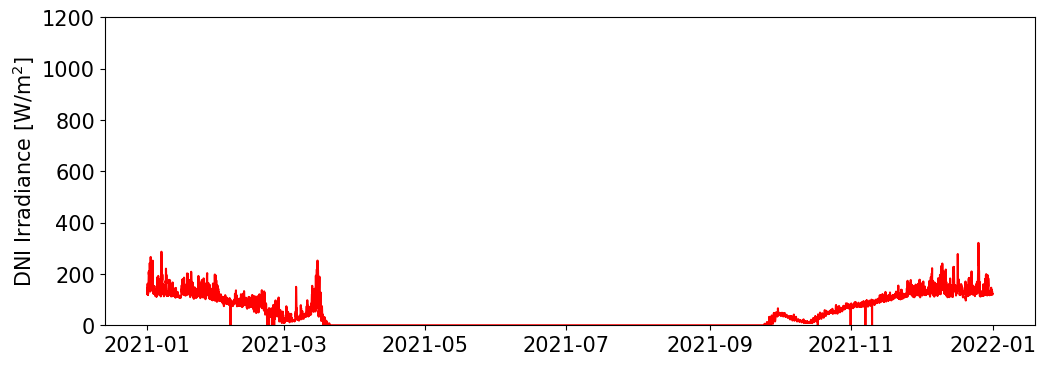

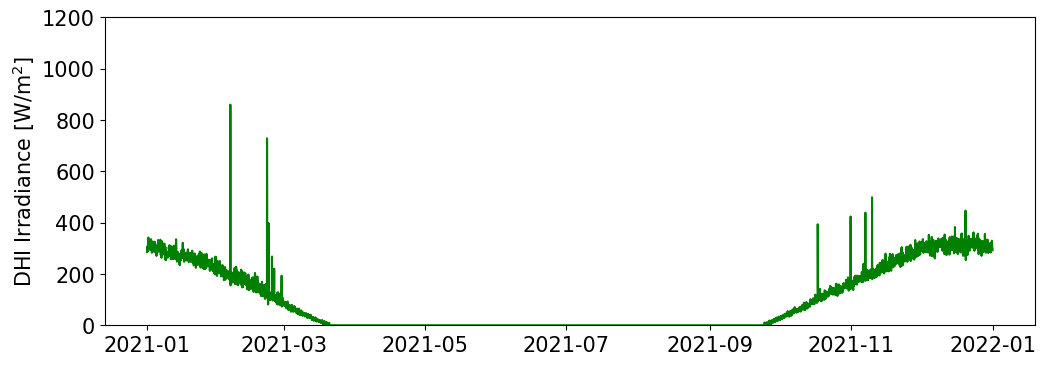

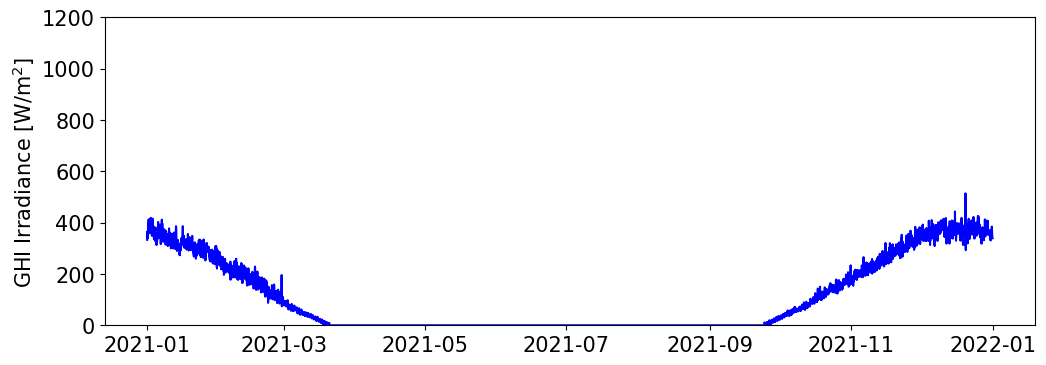

In [15]:
data = mindni.copy()

plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (12, 4)

plt.plot(data['dni'], 'r')
plt.ylabel('DNI Irradiance [W/m$^2$]')
plt.ylim([0, 1200])
plt.figure()
plt.plot(data['dhi'], 'g')
plt.ylabel('DHI Irradiance [W/m$^2$]')
plt.ylim([0, 1200])
plt.figure()
plt.plot(data['ghi'], 'b')
plt.ylabel('GHI Irradiance [W/m$^2$]')
plt.ylim([0, 1200])
